The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
LX-T 313
YSZ-T 260
M-T 300
LX-YSZ 460
LX-M 300
YSZ-M 300
LX-T 313
YSZ-T 260
M-T 300
LX-YSZ 460
LX-M 300
YSZ-M 300


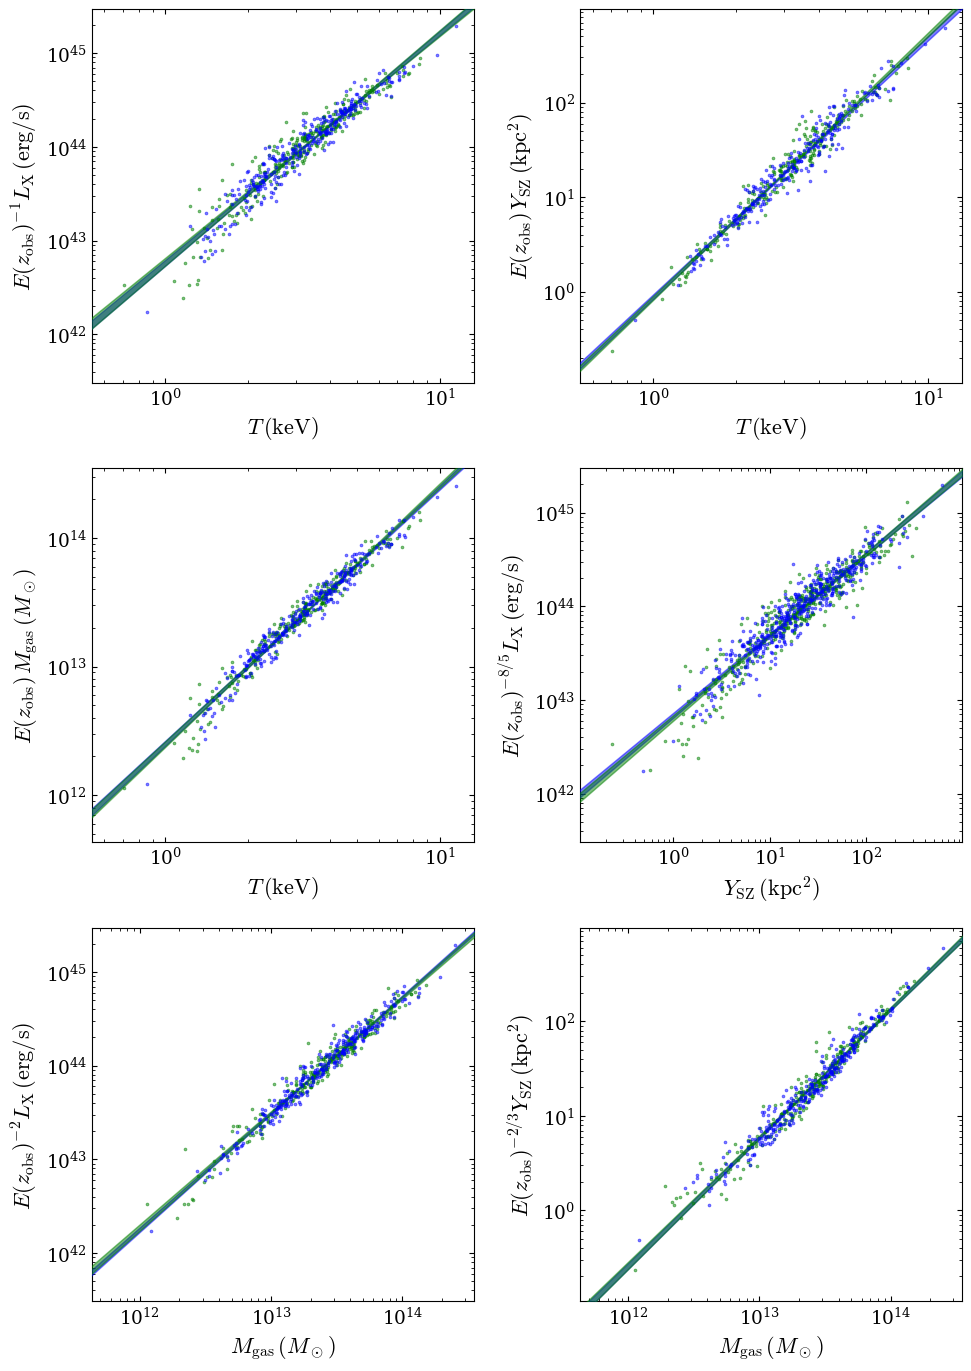

In [5]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tools.clusterfit as cf
plt.style.use('nice.mplstyle')

scatter_colors = ['b', 'g']
scatter_markers = ['.', '.']
fitline_colors = ['b', 'g']
facecolors = ['b', 'g']

# Initialize a plot
fig, axs = plt.subplots(3, 2, figsize=(10, 14))
for lc in [0, 1]:
    # Load the data
    df_sample = pd.read_csv(f'../data/samples_in_lightcone{lc}_with_trees_duplicate_excision_outlier_excision.csv')
    df_fitall = pd.read_csv(f'../scripts/fit-all-lightcone{lc}.csv')

    # The relations we have
    relations = df_fitall['relation'].values


    # The plotting ranges for each quantity is fixed
    ranges = {
        'LX' : [df_sample[cf.COLUMNS['LX']].min(),  df_sample[cf.COLUMNS['LX']].max()],
        'YSZ': [df_sample[cf.COLUMNS['YSZ']].min(), df_sample[cf.COLUMNS['YSZ']].max()],
        'M'  : [df_sample[cf.COLUMNS['M']].min(),   df_sample[cf.COLUMNS['M']].max()],
        'T'  : [df_sample[cf.COLUMNS['T']].min(),   df_sample[cf.COLUMNS['T']].max()],
    }

    labels = {
        'LX'  : '$L_\\mathrm{{X}}\\,(\\mathrm{{erg/s}})$',
        'YSZ' : '$Y_\\mathrm{{SZ}}\\,(\\mathrm{{kpc^2}})$',
        'M'   : '$M_\\mathrm{{gas}}\\,(M_\\odot)$',
        'T'   : '$T\\,(\\mathrm{{keV}})$',
    }


    
    i = 0
    for row in axs:
        for ax in row:
            relation = relations[i]

            # Use the first n_cluster 
            n_clusters = cf.CONST[relation]['N']
            df = df_sample[:n_clusters]
            print(relation, n_clusters)
            CX = cf.CONST[relation]['CX']
            CY = cf.CONST[relation]['CY']

            # Get x, y names
            _ = relation.find('-')
            yname = relation[:_]
            xname = relation[_+1:]
            # print(xname, yname)

            # Load the data with column names
            Y = df[cf.COLUMNS[yname]].values
            X = df[cf.COLUMNS[xname]].values
            redshift = df['ObservedRedshift'].values

            logY_ = cf.logY_(Y, relation=relation, z=redshift)
            logX_ = cf.logX_(X, relation=relation) # the constants are already defined provided relation name

            # Plot the scatter 
            ax.scatter(CX*10**logX_, CY*10**logY_, marker=scatter_markers[lc], 
                       s=15, alpha=0.5, linewidth=0.7, facecolor=facecolors[lc],
                       color=scatter_colors[lc], zorder=100-lc)
            
            # ------------------------------------------------------------------

            # Plot the best fit
            mask = (df_fitall['relation'] == relation)

            # df_fral : DataFrame_FitAll_ReLation
            df_farl = df_fitall[mask]
            A = df_farl['A'].values[0]
            B = df_farl['B'].values[0]
            # print(A, B)
            xmin = np.min(logX_)
            xmax = np.max(logX_)
            logxrange = xmax - xmin
            linlogX_ = np.linspace(xmin-0.3*logxrange, xmax+0.3*logxrange, 100)

            # Plot the best fit
            # ax.plot(linlogX_, np.log10(A)+B*linlogX_)


            # Plot the error
            A_upper = df_farl['A_upper'].values[0]
            A_lower = df_farl['A_lower'].values[0]
            B_upper = df_farl['B_upper'].values[0]
            B_lower = df_farl['B_lower'].values[0]

            # Calculate the upper and lower bounds
            y_upper1 = np.log10(A + A_upper) + (B + B_upper) * linlogX_
            y_lower1 = np.log10(A - A_lower) + (B - B_lower) * linlogX_
            y_upper2 = np.log10(A + A_upper) + (B - B_lower) * linlogX_
            y_lower2 = np.log10(A - A_lower) + (B + B_upper) * linlogX_

            # Take the maximum and minimum of the bounds
            y_upper = np.maximum(y_upper1, y_upper2)
            y_lower = np.minimum(y_lower1, y_lower2)

            # Plot the confidence region
            ax.fill_between(CX*10**linlogX_, CY*10**y_lower, CY*10**y_upper, 
                            color=fitline_colors[lc], alpha=0.5,
                            zorder=50+lc) # first lightcone on top


            # Set x, y label
            gamma = cf.CONST[relation]['gamma']
            gamma_str = cf.gamma_to_str(gamma)
            ax.set_xlabel(f'{labels[xname]}')
            ax.set_ylabel(f'$E(z_\\mathrm{{obs}})^{{{gamma_str}}}${labels[yname]}')

            # Set x, y scales
            ax.set_xscale('log')
            ax.set_yscale('log')


            # Set x, y lim as the range extended by 0.2 on both sides
            xlim0 = ranges[xname][0]
            xlim1 = ranges[xname][1]
            logxrange = np.log10(xlim1) - np.log10(xlim0)
            xlim0 = 10**(np.log10(xlim0) - 0.1 * logxrange)
            xlim1 = 10**(np.log10(xlim1) + 0.1 * logxrange)
            # y lim
            ylim0 = ranges[yname][0]
            ylim1 = ranges[yname][1]
            logyrange = np.log10(ylim1) - np.log10(ylim0)
            ylim0 = 10**(np.log10(ylim0) - 0.1 * logyrange)
            ylim1 = 10**(np.log10(ylim1) + 0.1 * logyrange)


            ax.set_xlim(xlim0, xlim1)
            ax.set_ylim(ylim0, ylim1)
            # Update relation index
            i += 1

plt.tight_layout()

plt.savefig(f'/Users/yujiehe/Documents/projects/project-anisotropy/plots/forpaper/results-fit-all.png', dpi=300, bbox_inches='tight')
plt.show()

